In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge

In [12]:
bike = pd.read_csv('day.csv')
processed_bike_data = pd.read_csv('preprocessed.csv')

In [13]:
def train_simple_linear_model(processed_bike_data, target_column, test_size=0.2, random_state=42):
    
    X = processed_bike_data.drop(target_column, axis=1)
    y = processed_bike_data[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    linear_model = LinearRegression()
    linear_model.fit(X_train, y_train)

    y_pred = linear_model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {mse**0.5}")
    print(f"R² Score: {r2}")

    return mse, r2
mse_simple, r2_simple = train_simple_linear_model(processed_bike_data, target_column='cnt')

Mean Squared Error (MSE): 691035.0082022649
Root Mean Squared Error (RMSE): 831.2851545662685
R² Score: 0.8276670090367213


In [14]:
def improved_linear_model(preprocessed_bike_data, target_column, test_size=0.2, random_state=42):
    X = preprocessed_bike_data.drop(target_column, axis=1)
    y = preprocessed_bike_data[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    f_values, p_values = f_regression(X_train, y_train)
    selected_features = X_train.columns[p_values < 0.05]
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    X_train_interaction = poly.fit_transform(X_train_selected)
    X_test_interaction = poly.transform(X_test_selected)

    ridge_model = Ridge(alpha=1.0)
    ridge_model.fit(X_train_interaction, y_train)

    y_pred = ridge_model.predict(X_test_interaction)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {mse**0.5}")
    print(f"R² Score: {r2}")

    return mse, mse**0.5, r2

mse_advanced, rmse_advanced, r2_advanced = improved_linear_model(processed_bike_data, target_column='cnt')

Mean Squared Error (MSE): 545745.9704365795
Root Mean Squared Error (RMSE): 738.7462151758069
R² Score: 0.8638997528704587


In [15]:
def train_random_forest(data, target_column='cnt', test_size=0.2, random_state=42, n_estimators=100):
    X = data.drop(target_column, axis=1)
    y = data[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    rf = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_test, y_pred)

    return {
        "model": rf,
        "mse": mse,
        "rmse": rmse,
        "r2": r2
    }

results = train_random_forest(processed_bike_data)

print(f"Mean Squared Error (MSE): {results['mse']}")
print(f"Root Mean Squared Error (RMSE): {results['rmse']}")
print(f"R²: {results['r2']}")

Mean Squared Error (MSE): 458446.9475870749
Root Mean Squared Error (RMSE): 677.0871048743101
R²: 0.8856707218333267


In [16]:
def train_and_optimize_random_forest(processed_bike_data, test_size=0.2, random_state=42, n_iter=50):
    X = processed_bike_data.drop('cnt', axis=1)
    y = processed_bike_data['cnt']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    random_param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    }

    rf_random_search = RandomizedSearchCV(
        estimator=RandomForestRegressor(random_state=random_state),
        param_distributions=random_param_grid,
        n_iter=n_iter,
        cv=3,
        scoring='r2',
        n_jobs=-1,
        random_state=random_state
    )

    rf_random_search.fit(X_train, y_train)

    best_rf_model_random = rf_random_search.best_estimator_
    best_params_random = rf_random_search.best_params_

    y_pred_optimized_random = best_rf_model_random.predict(X_test)
    mse_optimized_random = mean_squared_error(y_test, y_pred_optimized_random)
    rmse_optimized_random = mse_optimized_random ** 0.5
    r2_optimized_random = r2_score(y_test, y_pred_optimized_random)

    return best_params_random, mse_optimized_random, rmse_optimized_random, r2_optimized_random

best_params, mse, rmse, r2 = train_and_optimize_random_forest(processed_bike_data)
print("Best Parameters:", best_params)
print("MSE:", mse)
print("RMSE:", rmse)
print("R²:", r2)

Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20}
MSE: 494616.3304478202
RMSE: 703.2896490407207
R²: 0.8766506608296102


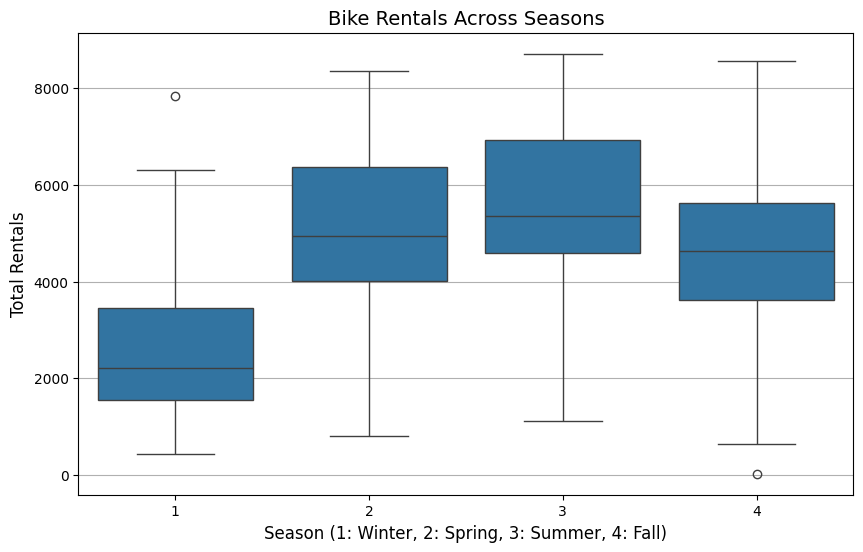

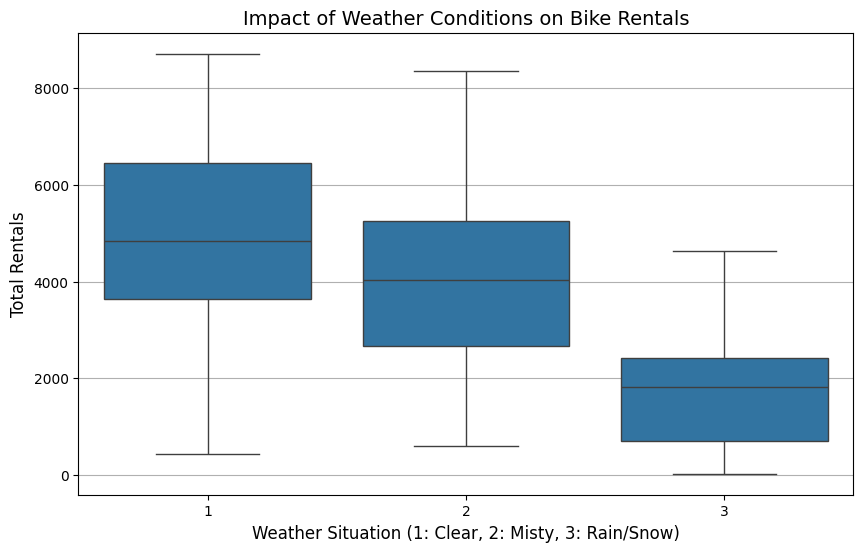

In [17]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='season', y='cnt', data=bike)
plt.title('Bike Rentals Across Seasons', fontsize=14)
plt.xlabel('Season (1: Winter, 2: Spring, 3: Summer, 4: Fall)', fontsize=12)
plt.ylabel('Total Rentals', fontsize=12)
plt.grid(axis='y')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='weathersit', y='cnt', data=bike)
plt.title('Impact of Weather Conditions on Bike Rentals', fontsize=14)
plt.xlabel('Weather Situation (1: Clear, 2: Misty, 3: Rain/Snow)', fontsize=12)
plt.ylabel('Total Rentals', fontsize=12)
plt.grid(axis='y')
plt.show()

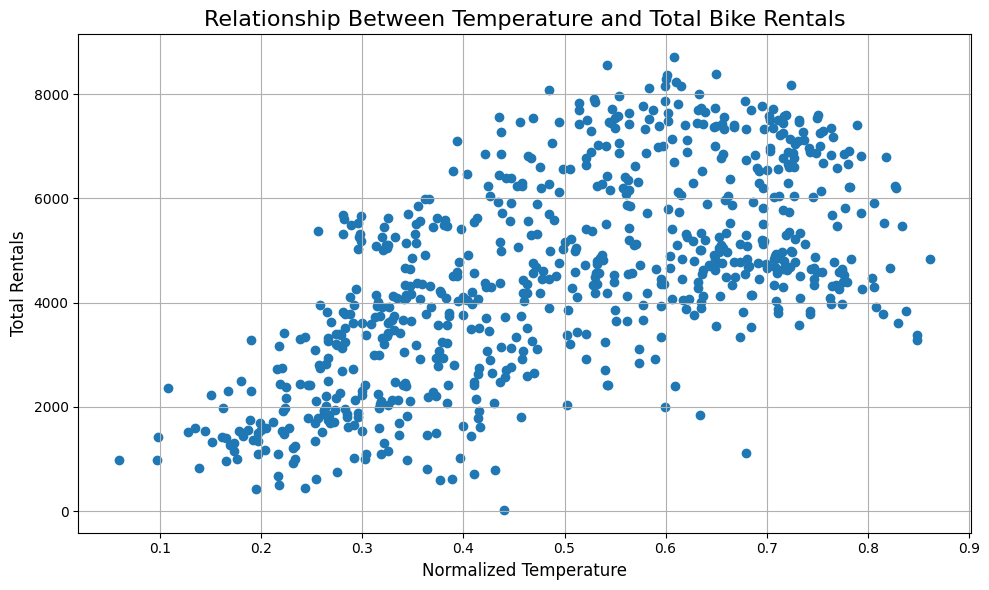

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(bike['temp'], bike['cnt'])
plt.title('Relationship Between Temperature and Total Bike Rentals', fontsize=16)
plt.xlabel('Normalized Temperature', fontsize=12)
plt.ylabel('Total Rentals', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()